# **Load Independences**

In [1]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.6 MB/s eta 0:00:00


# **Imports**

In [2]:
import warnings
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

import plotly.graph_objects as go
import plotly.express as px

# Function to remove special characters
from unidecode import unidecode

from tqdm.notebook import tqdm, trange

# Feature Eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Feature Importance
from sklearn.feature_selection import mutual_info_classif, chi2

# Dendogram
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Pre Processing
from sklearn.preprocessing import MinMaxScaler



my_palette = sns.diverging_palette(230, 20, as_cmap=False)
sns.set_theme(style="ticks", palette=my_palette)

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.feature_selection import mutual_info_classif

# **Data Sets**

## **Download Datasets**

In [4]:
#@title Download Datasets from GDrive

# ESC FREQ 1
!gdown 1IpQuBoxR79tHk8IIAZzwFWtUjzSLr6uZ

# Economic Level
!gdown 1hkzJTRxUQKvyqrw30rIpmrA1ZoiVd1oJ

# ESC RENDA
!gdown 1fyJ8bHzEZMnfBTimBxUTNjs5Jb436QiO

# Regions
!gdown 10uof0LSwNMTcl5w_XZI6B2WyyOFunhcm

Downloading...
From: https://drive.google.com/uc?id=1IpQuBoxR79tHk8IIAZzwFWtUjzSLr6uZ
To: /content/RAIS_ESC_FREQ.csv
100% 315k/315k [00:00<00:00, 71.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hkzJTRxUQKvyqrw30rIpmrA1ZoiVd1oJ
To: /content/results_scrapper_PCDII.csv
100% 698k/698k [00:00<00:00, 67.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fyJ8bHzEZMnfBTimBxUTNjs5Jb436QiO
To: /content/RAIS_IBGE_RENDA.csv
100% 1.64M/1.64M [00:00<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=10uof0LSwNMTcl5w_XZI6B2WyyOFunhcm
To: /content/regioes_geograficas.xlsx
100% 260k/260k [00:00<00:00, 82.9MB/s]


## **Load Datasets**

In [5]:
rais_freq = pd.read_csv('RAIS_ESC_FREQ.csv', encoding='ISO-8859-1', sep=';')
rais_freq.columns = [key.replace(' ','_').capitalize() for key in rais_freq.columns]

In [6]:
nve_df = pd.read_csv('results_scrapper_PCDII.csv', index_col=0)
nve_df.columns = [key.replace(' ','_').capitalize() for key in nve_df.columns]

In [7]:
rais_renda = pd.read_csv('RAIS_IBGE_RENDA.csv', encoding='ISO-8859-1', sep=';')
rais_renda.columns = [key.replace(' ','_').capitalize() for key in rais_renda.columns]

In [8]:
df_regions = pd.read_excel('/content/regioes_geograficas.xlsx')

# **Pre-Processing**

In [9]:
nve_df = nve_df.rename(columns={key: unidecode(key).replace(' ', '_') for key in nve_df.keys()})
rais_freq = rais_freq.rename(columns={key: unidecode(key).replace(' ', '_') for key in rais_freq.keys()})
rais_renda = rais_renda.rename(columns={key: unidecode(key).replace(' ', '_') for key in rais_renda.keys()})

In [10]:
#@title Get state and city in dataframe
#@markdown Separate State and City from the Municipio attribute

def format_city(city: str):

  city_without_special_charac = unidecode(city)

  city_capitalize = city_without_special_charac.capitalize()

  return city_capitalize


def append_state_and_city(frame, column_name: str):
  frame = frame.copy()

  state_and_city_frame = frame[column_name].apply(lambda x: x.split('-'))

  state = []
  city = []

  for row in state_and_city_frame:
    state.append(row[0])
    city.append(format_city(row[1]))

  frame = frame.drop(columns=[column_name])

  frame['Municipio'] = city

  frame['Estado'] = state

  frame = frame[frame.columns[-2:].tolist() + frame.columns[:-2].tolist()]

  return frame

In [11]:
rais_freq = append_state_and_city(rais_freq, 'Municipio')
rais_renda = append_state_and_city(rais_renda, 'No_municipio')

In [12]:
nve_df['Estado'] = nve_df['Nome'].str.extract(r'\((.*?)\)')

nve_df['Municipio'] = nve_df['Nome'].str.extract(r'^(.*?)(?:\s\()')

nve_df['Municipio'] = nve_df['Municipio'].apply(lambda x : format_city(x))

nve_df = nve_df[nve_df.columns[-2:].tolist() + nve_df.columns[:-2].tolist()]

In [13]:
aux_frame_freq = pd.merge(rais_freq, nve_df[['Estado','Municipio','Codigo','Latitude','Longitude','Populacao_estimada','Nivel_economica']], on=['Estado', 'Municipio'])

order_columns = ['Municipio', 'Estado', 'Codigo', 'Latitude', 'Longitude', 'Analfabeto', 'Ate_5_incompleto',
          '5_completo_fundamental', '6_a_9_fundamental', 'Fundamental_completo',
          'Medio_incompleto', 'Medio_completo', 'Superior_incompleto',
          'Superior_completo', 'Mestrado', 'Doutorado', 'Total', 'Populacao_estimada', 'Nivel_economica']

aux_frame_freq = aux_frame_freq[order_columns]

In [14]:
aux_frame_renda = pd.merge(rais_freq, nve_df[['Estado','Municipio','Codigo']], on=['Estado', 'Municipio'])
aux_frame_renda = aux_frame_renda.drop(columns=['Municipio', 'Estado'])

In [15]:
aux_frame_freq = aux_frame_freq.rename(columns={key: unidecode(key).replace(' ', '_') + '_freq' if key != 'Codigo' else  unidecode(key).replace(' ', '_')  for key in aux_frame_freq.keys()})
aux_frame_renda = aux_frame_renda.rename(columns={key: unidecode(key).replace(' ', '_') + '_renda' if key != 'Codigo' else  unidecode(key).replace(' ', '_') for key in aux_frame_renda.keys()})

In [16]:
df = pd.merge(aux_frame_freq, aux_frame_renda, how='inner', on='Codigo')
df = df.rename(columns={'Latitude_freq':'Latitude', 'Longitude_freq':'Longitude',
                        'Estado_freq':'Estado', 'Municipio_freq':'Municipio',
                        'Nivel_economica_freq':'Nivel_economico'})

<Axes: >

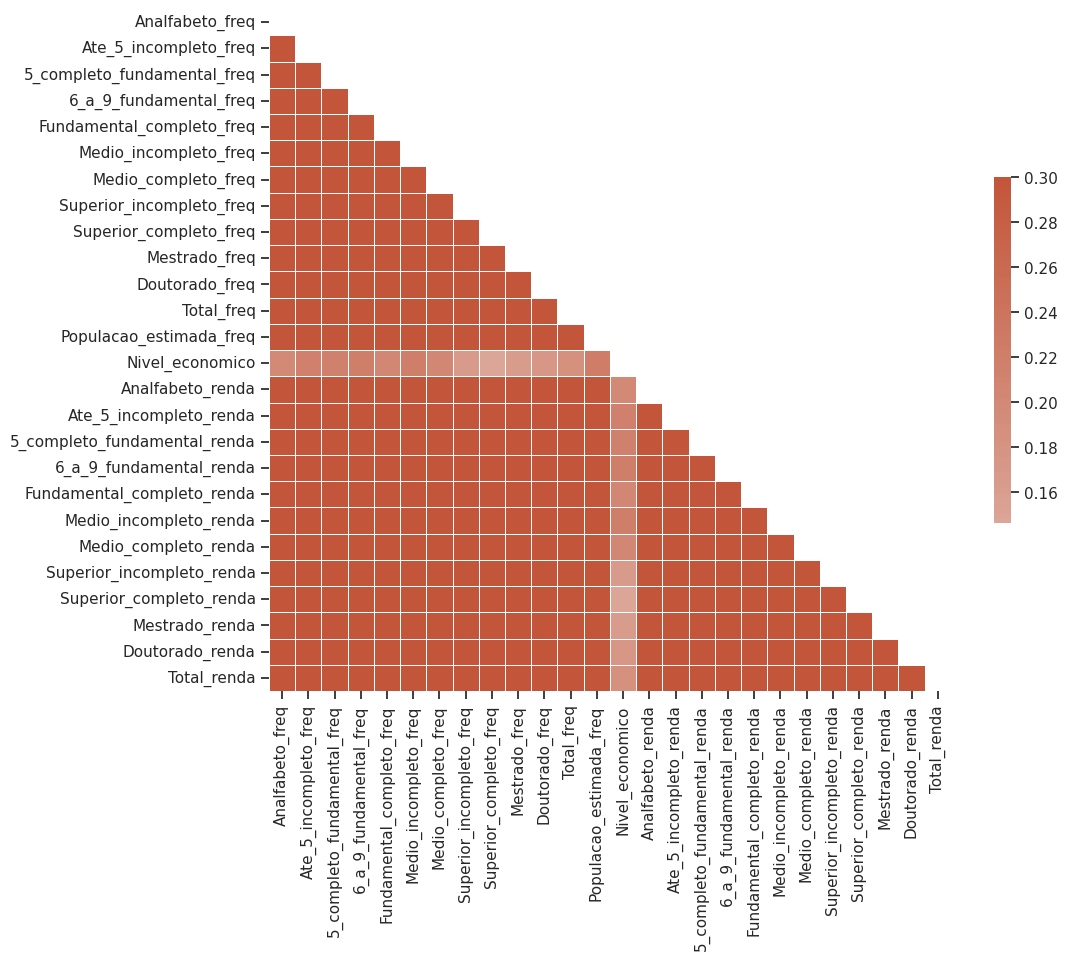

In [17]:
corr = df.iloc[:, 5:].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **Dendogram**

## **Core**

In [18]:
scaler = MinMaxScaler()

df_normalized = df.drop(columns=['Nivel_economico'])

df_normalized = scaler.fit_transform(df_normalized.iloc[:, 5:])

df_normalized = pd.DataFrame(df_normalized, columns=scaler.get_feature_names_out())

## **Hierarchy Dendogram**

In [ ]:
# Clustering Method
Z = linkage(df_normalized, method='ward')

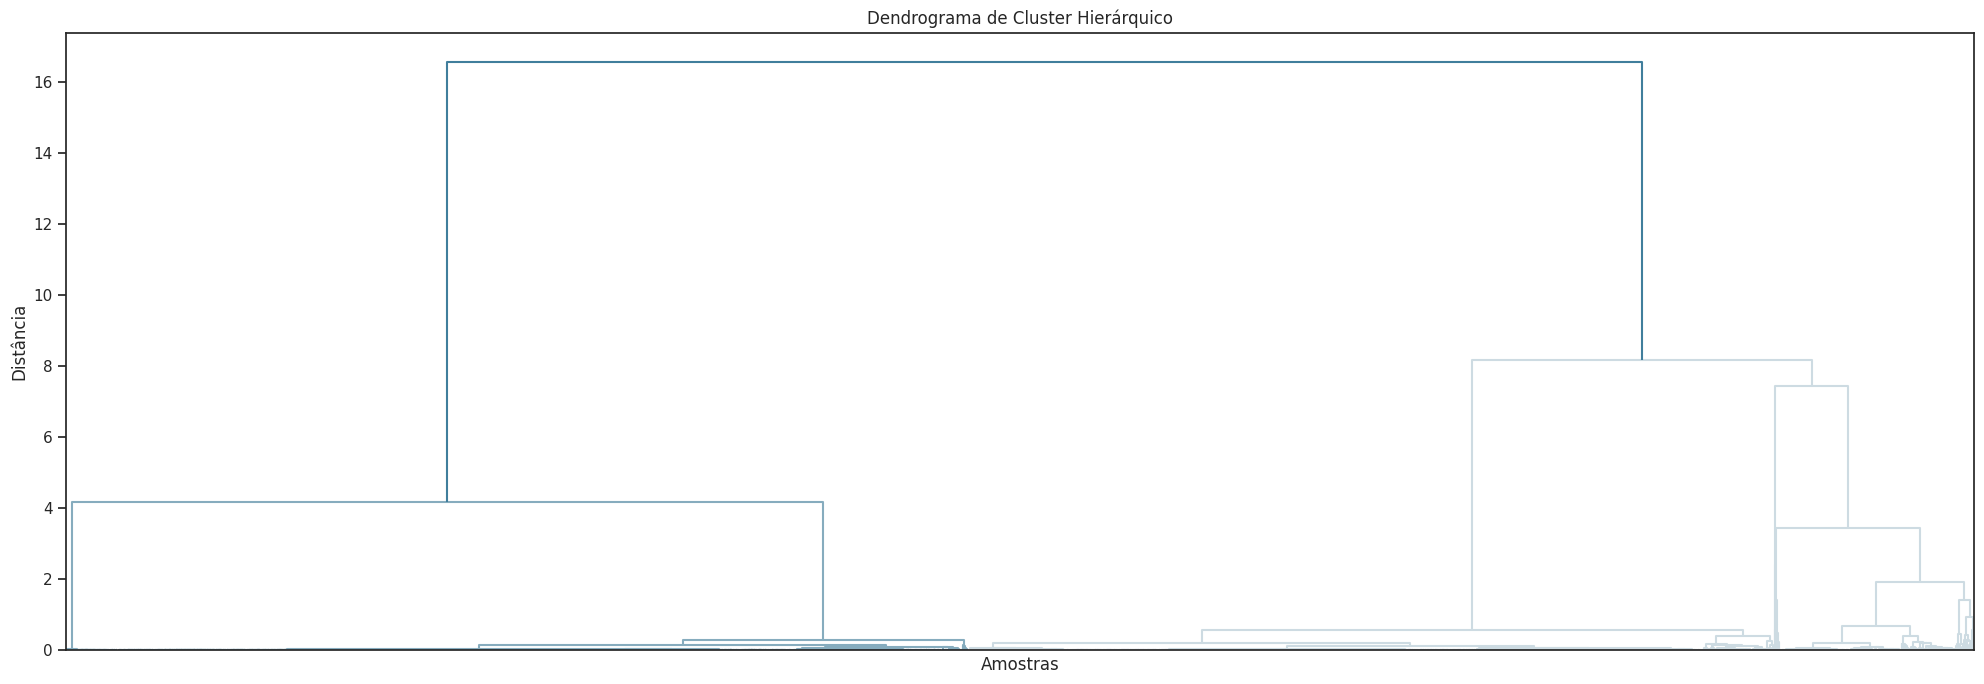

In [ ]:
plt.figure(figsize=(20, 7))
dendrogram(Z)

plt.title('Dendrograma de Cluster Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')

plt.xticks([])

plt.tight_layout()
plt.show()

Numero de Clutests ::  10


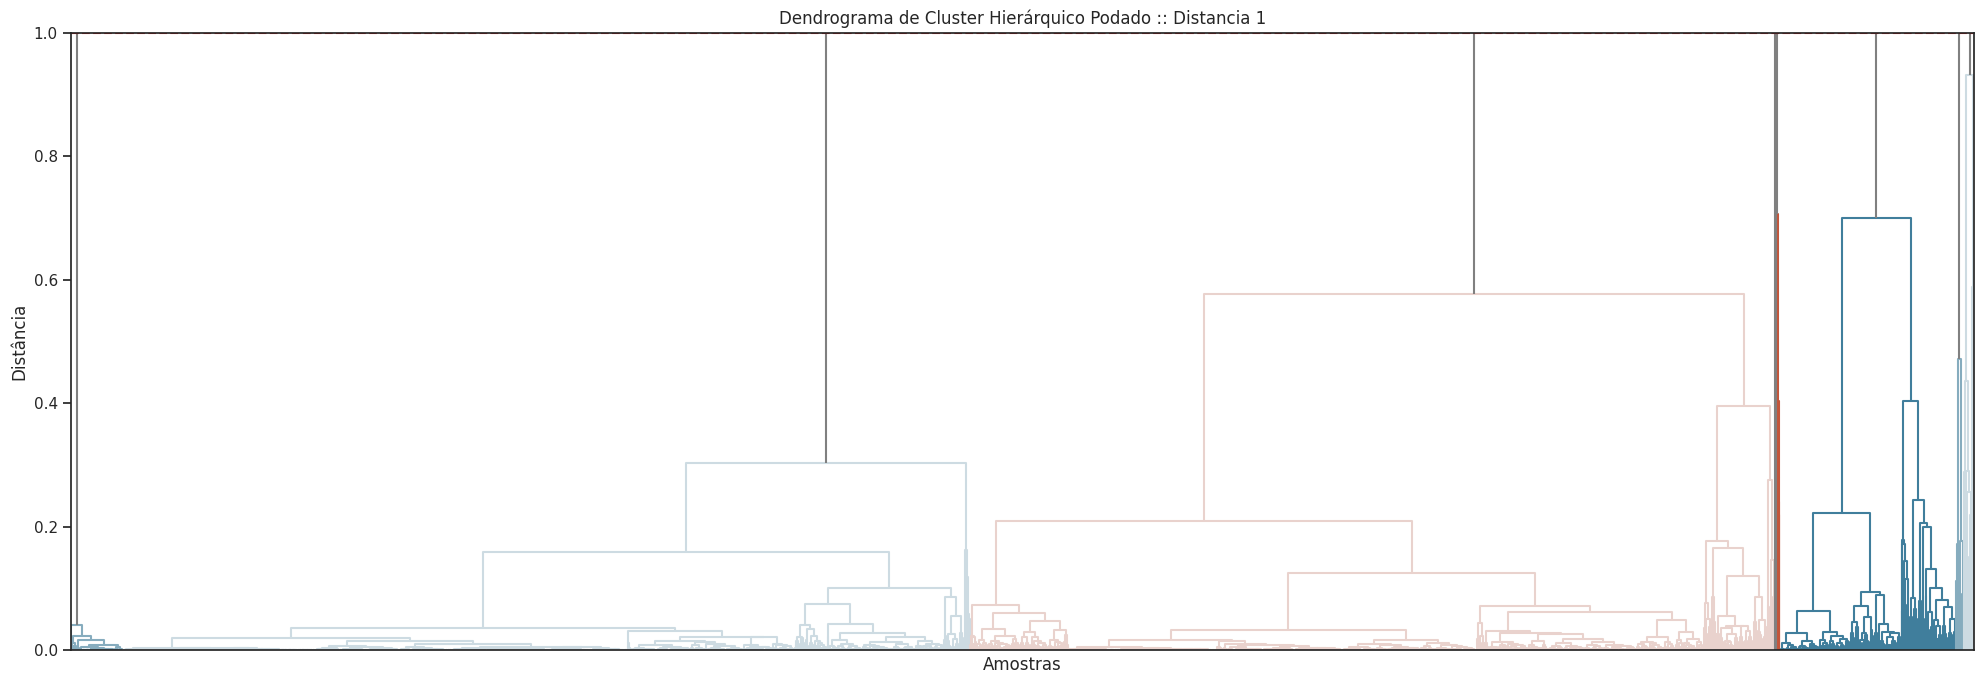

In [ ]:
cut_distance = 1
clusters = fcluster(Z, t=cut_distance, criterion='distance')

unique_clusters = np.unique(clusters)
print(f'Numero de Clutests :: ', len(unique_clusters))

plt.figure(figsize=(20, 7))

dendrogram(Z, above_threshold_color='gray', color_threshold=cut_distance)

plt.title(f'Dendrograma de Cluster Hierárquico Podado :: Distancia {cut_distance}')

plt.axhline(y=cut_distance, color='red', linestyle='--')
plt.ylim(0, cut_distance)

plt.xlabel('Amostras')
plt.ylabel('Distância')

plt.xticks([])

plt.tight_layout()
plt.show()

Numero de Clutests ::  37


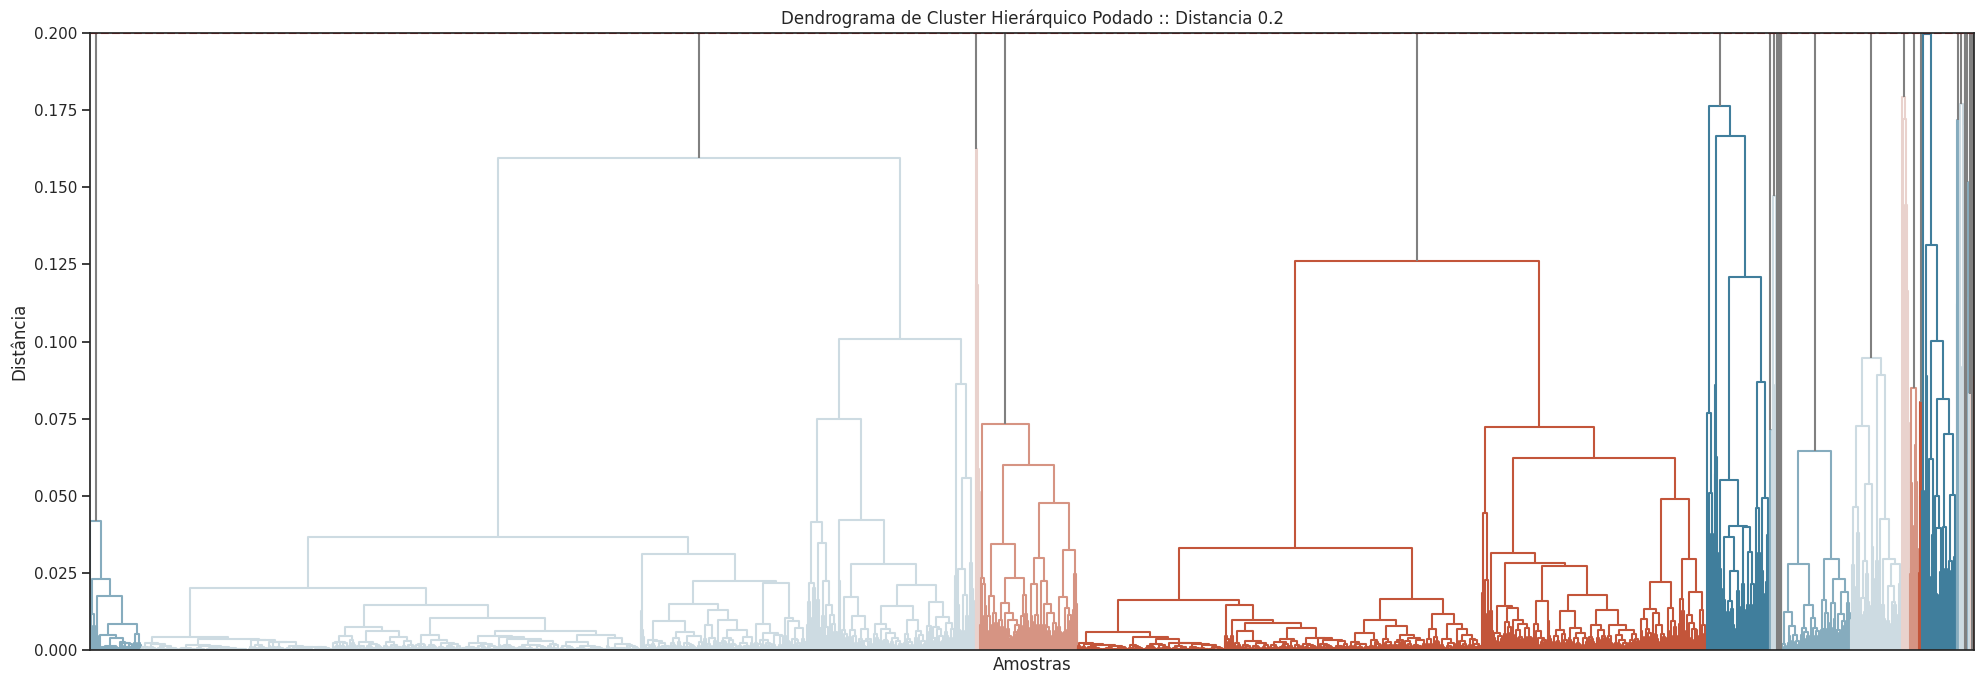

In [ ]:
cut_distance = 0.2
clusters = fcluster(Z, t=cut_distance, criterion='distance')

unique_clusters = np.unique(clusters)
print(f'Numero de Clutests :: ', len(unique_clusters))

plt.figure(figsize=(20, 7))

dendrogram(Z, above_threshold_color='gray', color_threshold=cut_distance)

plt.title(f'Dendrograma de Cluster Hierárquico Podado :: Distancia {cut_distance}')

plt.axhline(y=cut_distance, color='red', linestyle='--')
plt.ylim(0, cut_distance)

plt.xlabel('Amostras')
plt.ylabel('Distância')

plt.xticks([])

plt.tight_layout()
plt.show()

Numero de Clutests ::  57


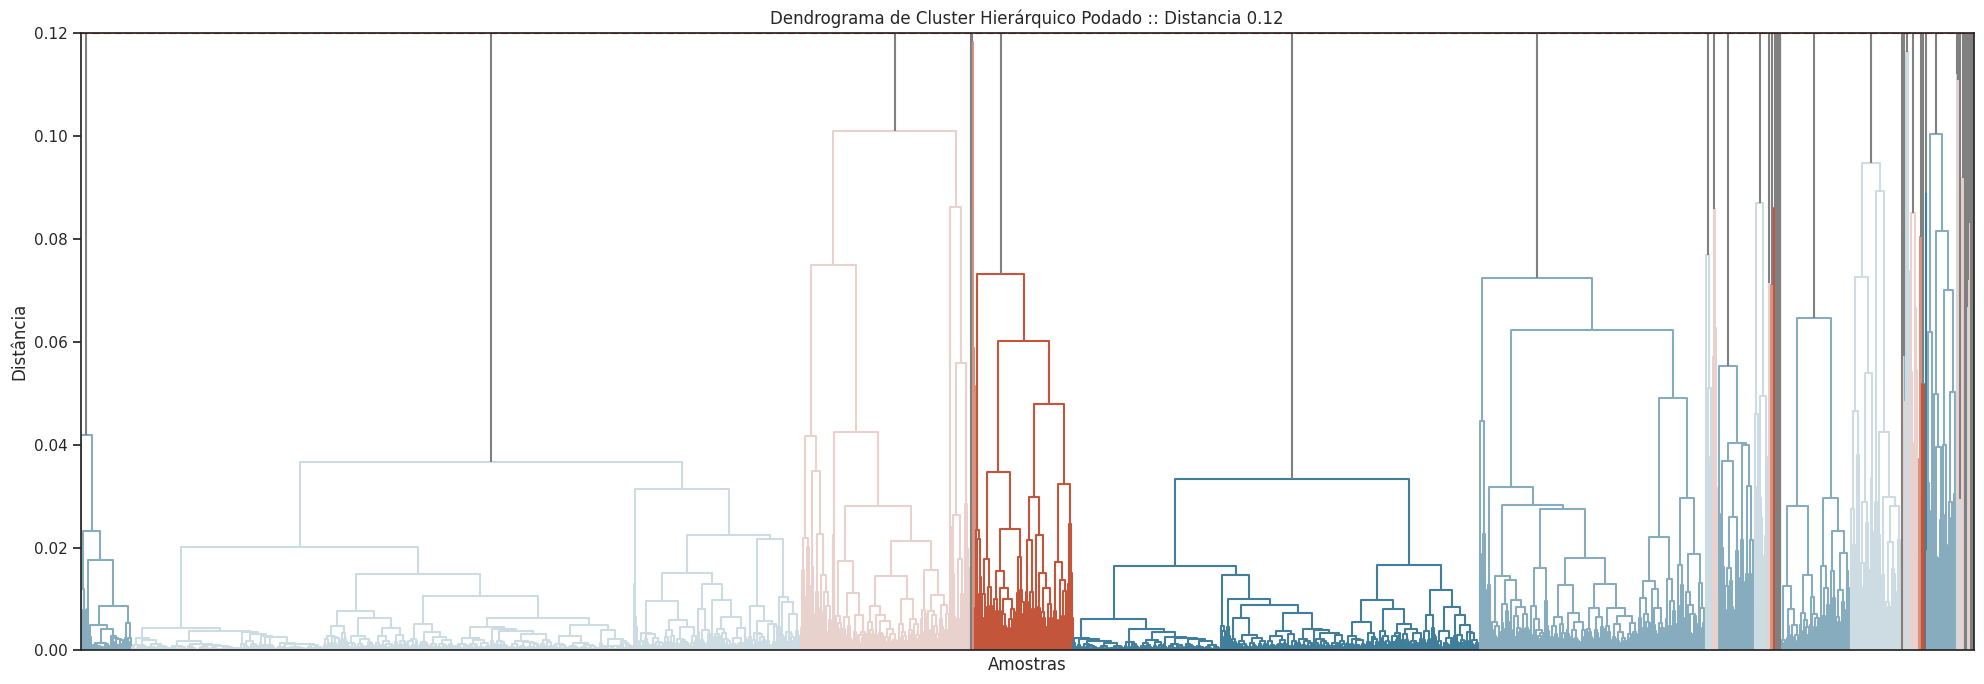

In [ ]:
cut_distance = 0.120
clusters = fcluster(Z, t=cut_distance, criterion='distance')

unique_clusters = np.unique(clusters)
print(f'Numero de Clutests :: ', len(unique_clusters))

plt.figure(figsize=(20, 7))

dendrogram(Z, above_threshold_color='gray', color_threshold=cut_distance)

plt.title(f'Dendrograma de Cluster Hierárquico Podado :: Distancia {cut_distance}')

plt.axhline(y=cut_distance, color='red', linestyle='--')
plt.ylim(0, cut_distance)

plt.xlabel('Amostras')
plt.ylabel('Distância')

plt.xticks([])

plt.tight_layout()
plt.show()

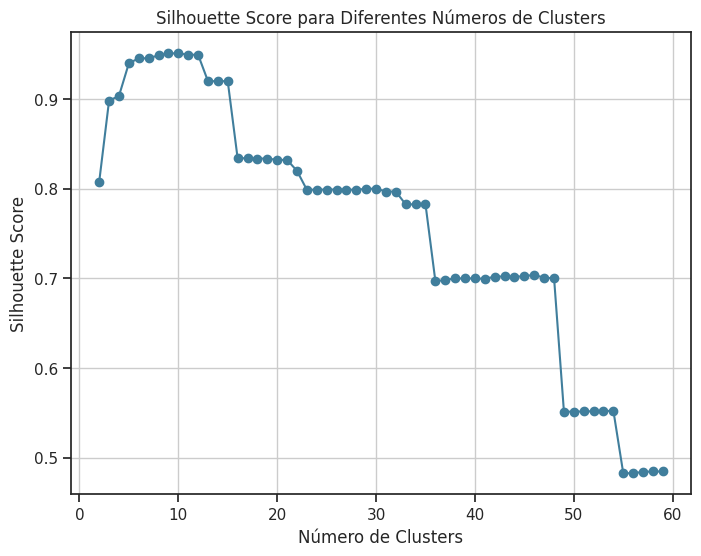

In [ ]:
silhouette_scores = []
num_clusters_range = range(2, 60)

for n_clusters in num_clusters_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = clustering.fit_predict(df_normalized)
    silhouette_avg = silhouette_score(df_normalized, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

## **Bootstrap Original Data Set**

- Boostrap metodo de cotovelo, silhueta
- Analise de variavel por cluster
- Ver se os clusters formados apresentam alguma relação espacial (vulgo sao proximos)

In [20]:
#@title Boostrap
num_samples = 50
stats = {'silhouete':[],
         'davies_bouldin':[]}

n = len(df_normalized)
num_clusters_range = range(2, 15)

for _ in trange(num_samples):

    aux_frame = df.drop(columns=['Nivel_economico'])

    aux_frame = aux_frame.sample(n=n, replace=True)

    scaler = MinMaxScaler()
    aux_frame = scaler.fit_transform(aux_frame.iloc[:, 5:])
    aux_frame = pd.DataFrame(aux_frame, columns=scaler.get_feature_names_out())

    silhouette_scores = []
    db_scores = []
    for n_clusters in num_clusters_range:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
        labels = clustering.fit_predict(aux_frame)

        silhouette_avg = silhouette_score(aux_frame, labels)
        silhouette_scores.append(silhouette_avg)

        db_score = davies_bouldin_score(aux_frame, labels)
        db_scores.append(db_score)

    best_num_clusters = num_clusters_range[np.argmax(silhouette_scores)]
    stats['silhouete'].append(best_num_clusters)

    best_num_clusters = num_clusters_range[np.argmin(db_scores)]
    stats['davies_bouldin'].append(best_num_clusters)

  0%|          | 0/50 [00:00<?, ?it/s]

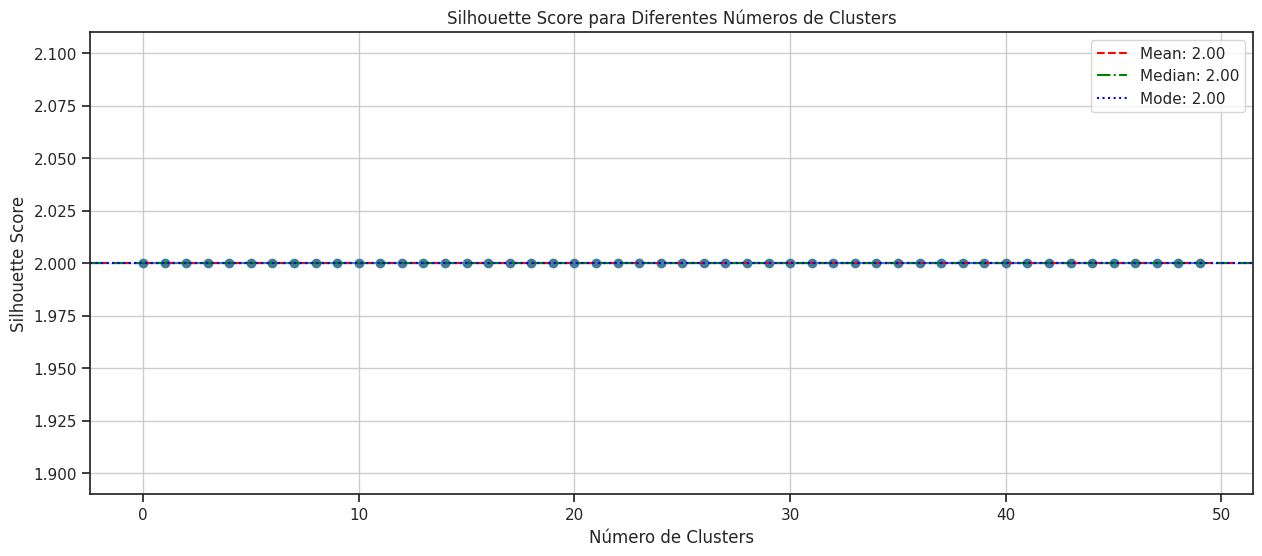

In [21]:
#@title Silhuete Score
plt.figure(figsize=(15, 6))
plt.plot(range(num_samples), stats['silhouete'], marker='o')
plt.title('Silhouette Score para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid()

mean_ = np.mean(stats['silhouete'])
median_ = np.median(stats['silhouete'])
mode_ = float(np.bincount(stats['silhouete']).argmax())

plt.axhline(mean_, color='r', linestyle='--', label=f'Mean: {mean_:.2f}')
plt.axhline(median_, color='g', linestyle='-.', label=f'Median: {median_:.2f}')
plt.axhline(mode_, color='b', linestyle=':', label=f'Mode: {mode_:.2f}')

plt.legend()
plt.show()

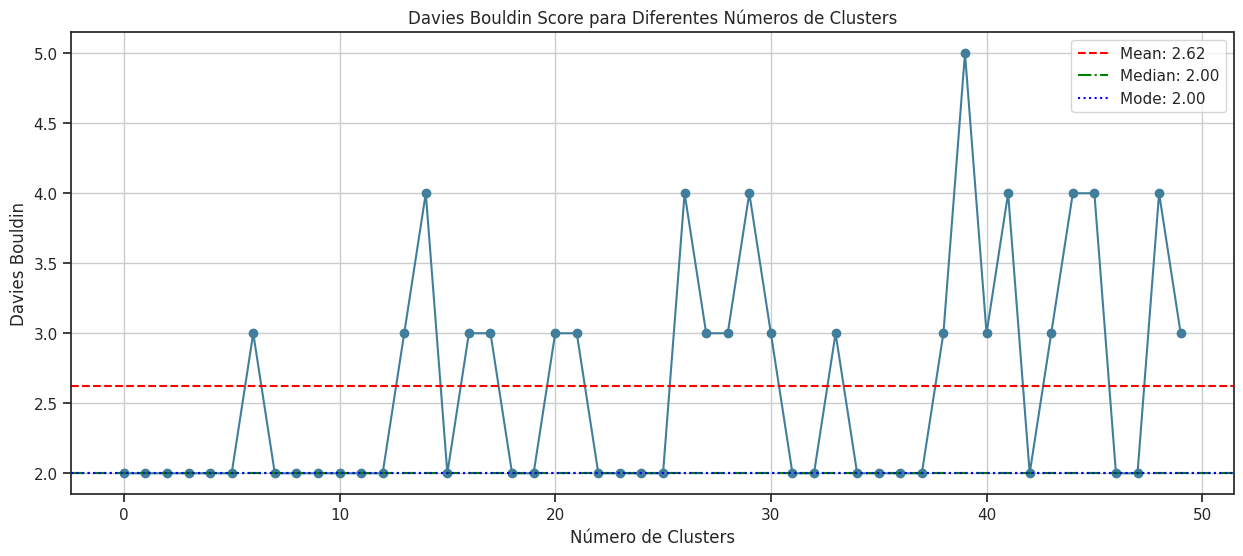

In [22]:
#@title Davies Bouldin Score
#@markdown Mede o quão bem os clusters estão separados uns dos outros, considerando a compactação e a distância entre eles.
#@markdown - Dispersão dentro do cluster: Mede o quão próximos os pontos estão em relação ao centro do cluster. Quanto menor, mais coeso é o cluster.
#@markdown - Distância entre clusters: Mede a separação entre o centro de i e o centro de outros clusters j

#@markdown A métrica compara a dispersão dentro do cluster com a distância entre clusters, e seleciona o pior caso (maior razão) para cada cluster. Depois, calcula a média dessas razões entre todos os clusters.

#@markdown Valores menores de Davies-Bouldin indicam melhores separações entre clusters e maior coesão interna.

plt.figure(figsize=(15, 6))
plt.plot(range(num_samples), stats['davies_bouldin'], marker='o')
plt.title('Davies Bouldin Score para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies Bouldin')
plt.grid()

mean_ = np.mean(stats['davies_bouldin'])
median_ = np.median(stats['davies_bouldin'])
mode_ = float(np.bincount(stats['davies_bouldin']).argmax())

plt.axhline(mean_, color='r', linestyle='--', label=f'Mean: {mean_:.2f}')
plt.axhline(median_, color='g', linestyle='-.', label=f'Median: {median_:.2f}')
plt.axhline(mode_, color='b', linestyle=':', label=f'Mode: {mode_:.2f}')

plt.legend()
plt.show()

In [23]:
#@title Define Best Features
# Define Clusters
n_clusters = 2
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward'
)
labels = clustering.fit_predict(df_normalized)

# Compute MI
clusters_mi = {}
for cluster_label in np.unique(labels):
    cluster_indexes = labels == cluster_label
    X = df_normalized.iloc[cluster_indexes, :]
    Y = df['Nivel_economico'].iloc[cluster_indexes]

    if len(X) > 2:
        mi = mutual_info_classif(X, Y, random_state=0)
        clusters_mi[cluster_label] = pd.DataFrame(mi.reshape(-1, 1), index=X.keys(), columns=['Mutual_information']).sort_values(by=['Mutual_information'], ascending=False)


#Print Infos
for index in clusters_mi:
    print(f'Cluster {index}')
    display(clusters_mi[index].iloc[:3])

Cluster 0


,Mutual_information
Total_freq,0.249351
Total_renda,0.249313
Medio_incompleto_freq,0.238884


## **Boostrap Normalized Population Size**

In [24]:
#@title Boostrap
num_samples = 50
stats = {'silhouete':[],
         'davies_bouldin':[]}

n = len(df_normalized)
num_clusters_range = range(2, 15)

for _ in trange(num_samples):
    aux_frame = df.drop(columns=['Nivel_economico'])
    aux_frame = aux_frame.iloc[:, 5:]

    aux_frame = aux_frame.sample(n=n, replace=True)
    for key in aux_frame:
      aux_frame[key] /= aux_frame['Populacao_estimada_freq']
    aux_frame = aux_frame.drop(columns=['Populacao_estimada_freq'])

    silhouette_scores = []
    db_scores = []
    for n_clusters in num_clusters_range:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
        labels = clustering.fit_predict(aux_frame)

        silhouette_avg = silhouette_score(aux_frame, labels)
        silhouette_scores.append(silhouette_avg)

        db_score = davies_bouldin_score(aux_frame, labels)
        db_scores.append(db_score)

    best_num_clusters = num_clusters_range[np.argmax(silhouette_scores)]
    stats['silhouete'].append(best_num_clusters)

    best_num_clusters = num_clusters_range[np.argmin(db_scores)]
    stats['davies_bouldin'].append(best_num_clusters)

  0%|          | 0/50 [00:00<?, ?it/s]

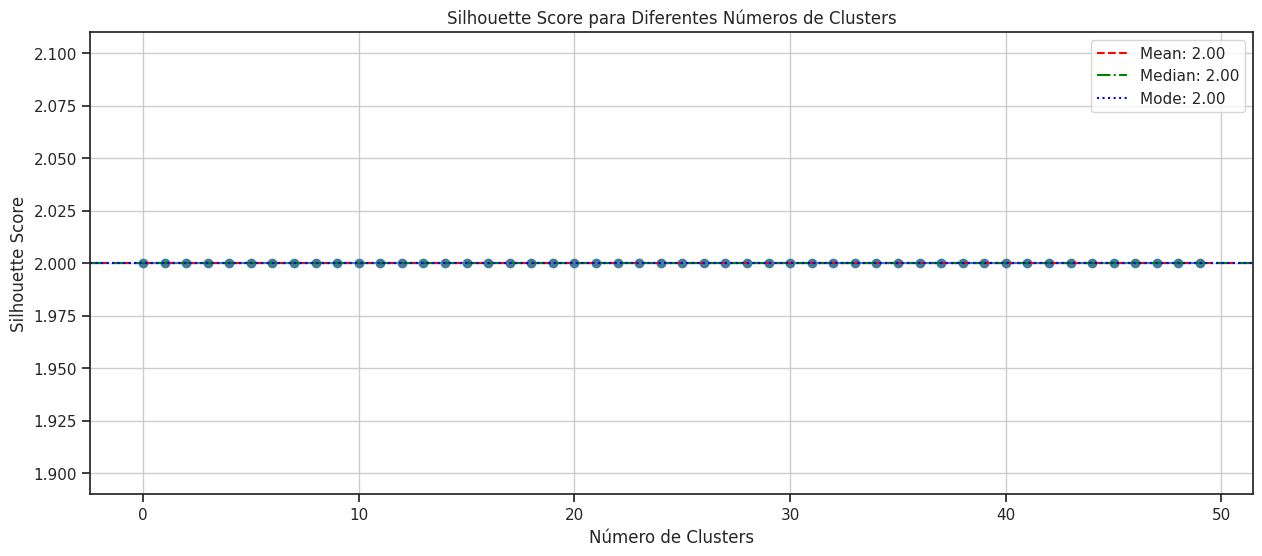

In [25]:
#@title Silhuete Score
plt.figure(figsize=(15, 6))
plt.plot(range(num_samples), stats['silhouete'], marker='o')
plt.title('Silhouette Score para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid()

mean_ = np.mean(stats['silhouete'])
median_ = np.median(stats['silhouete'])
mode_ = float(np.bincount(stats['silhouete']).argmax())

plt.axhline(mean_, color='r', linestyle='--', label=f'Mean: {mean_:.2f}')
plt.axhline(median_, color='g', linestyle='-.', label=f'Median: {median_:.2f}')
plt.axhline(mode_, color='b', linestyle=':', label=f'Mode: {mode_:.2f}')

plt.legend()
plt.show()

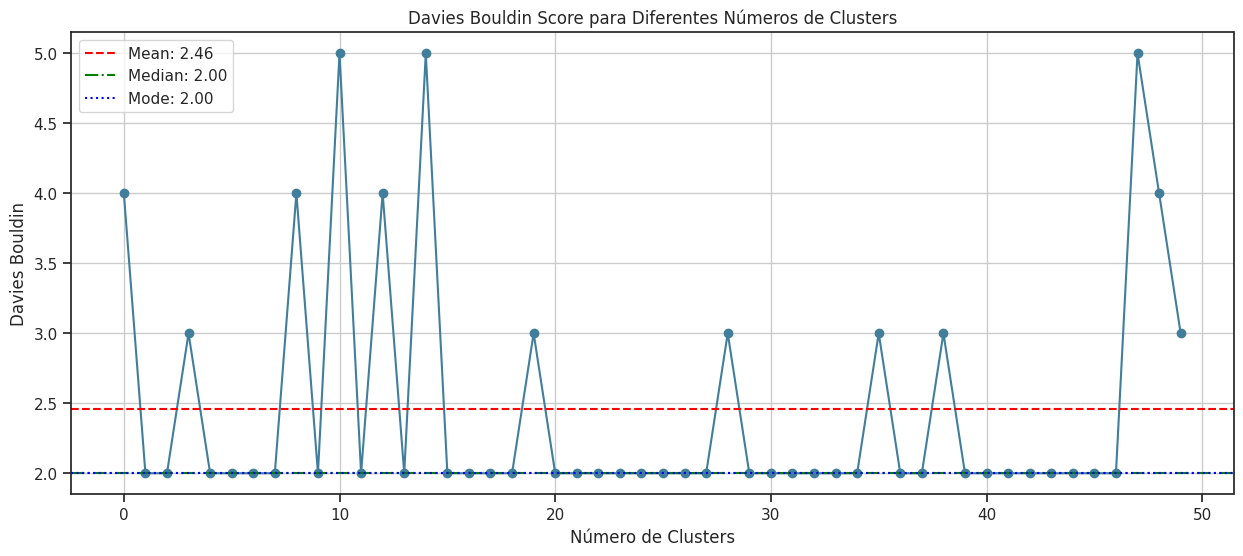

In [26]:
#@title Davies Bouldin Score
plt.figure(figsize=(15, 6))
plt.plot(range(num_samples), stats['davies_bouldin'], marker='o')
plt.title('Davies Bouldin Score para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies Bouldin')
plt.grid()

mean_ = np.mean(stats['davies_bouldin'])
median_ = np.median(stats['davies_bouldin'])
mode_ = float(np.bincount(stats['davies_bouldin']).argmax())

plt.axhline(mean_, color='r', linestyle='--', label=f'Mean: {mean_:.2f}')
plt.axhline(median_, color='g', linestyle='-.', label=f'Median: {median_:.2f}')
plt.axhline(mode_, color='b', linestyle=':', label=f'Mode: {mode_:.2f}')

plt.legend()
plt.show()

In [27]:
#@title Define Best Features
# Define Clusters
n_clusters = 2
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward'
)
labels = clustering.fit_predict(df_normalized)

# Compute MI
clusters_mi = {}
for cluster_label in np.unique(labels):
    cluster_indexes = labels == cluster_label
    X = df_normalized.iloc[cluster_indexes, :]
    Y = df['Nivel_economico'].iloc[cluster_indexes]

    display(X)

    if len(X) > 2:
        mi = mutual_info_classif(X, Y, random_state=0)
        clusters_mi[cluster_label] = pd.DataFrame(mi.reshape(-1, 1), index=X.keys(), columns=['Mutual_information']).sort_values(by=['Mutual_information'], ascending=False)


#Print Infos
for index in clusters_mi:
    print(f'Cluster {index}')
    display(clusters_mi[index].iloc[:3])

,Analfabeto_freq,Ate_5_incompleto_freq,5_completo_fundamental_freq,6_a_9_fundamental_freq,Fundamental_completo_freq,Medio_incompleto_freq,Medio_completo_freq,Superior_incompleto_freq,Superior_completo_freq,Mestrado_freq,...,5_completo_fundamental_renda,6_a_9_fundamental_renda,Fundamental_completo_renda,Medio_incompleto_renda,Medio_completo_renda,Superior_incompleto_renda,Superior_completo_renda,Mestrado_renda,Doutorado_renda,Total_renda
0,0.006733,0.007897,0.005914,0.005381,0.002637,0.007022,0.005216,0.002852,0.001787,0.002226,...,0.005914,0.005381,0.002637,0.007022,0.005216,0.002852,0.001787,0.002226,0.000781,0.003956
1,0.000243,0.000161,0.000767,0.000323,0.000186,0.000212,0.000193,0.000064,0.000093,0.000000,...,0.000767,0.000323,0.000186,0.000212,0.000193,0.000064,0.000093,0.000000,0.000049,0.000161
2,0.004056,0.008971,0.004806,0.004778,0.003619,0.006048,0.004528,0.003889,0.001811,0.003107,...,0.004806,0.004778,0.003619,0.006048,0.004528,0.003889,0.001811,0.003107,0.001122,0.003689
3,0.000487,0.001307,0.001704,0.001073,0.000564,0.000965,0.000631,0.000379,0.000268,0.000661,...,0.001704,0.001073,0.000564,0.000965,0.000631,0.000379,0.000268,0.000661,0.000000,0.000541
4,0.000649,0.001379,0.000852,0.001158,0.000663,0.000673,0.000615,0.000322,0.000238,0.000000,...,0.000852,0.001158,0.000663,0.000673,0.000615,0.000322,0.000238,0.000000,0.000000,0.000503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5485,0.001541,0.002417,0.001926,0.002491,0.000892,0.001252,0.000545,0.000440,0.000258,0.000073,...,0.001926,0.002491,0.000892,0.001252,0.000545,0.000440,0.000258,0.000073,0.000000,0.000579
5486,0.001704,0.002758,0.000937,0.002442,0.001154,0.001642,0.000389,0.000211,0.000166,0.000024,...,0.000937,0.002442,0.001154,0.001642,0.000389,0.000211,0.000166,0.000024,0.000000,0.000487
5487,0.000487,0.001021,0.000597,0.000652,0.000229,0.000230,0.000472,0.000043,0.000085,0.000269,...,0.000597,0.000652,0.000229,0.000230,0.000472,0.000043,0.000085,0.000269,0.000000,0.000311
5488,0.001217,0.001880,0.000716,0.001116,0.000753,0.000566,0.000262,0.000218,0.000120,0.000000,...,0.000716,0.001116,0.000753,0.000566,0.000262,0.000218,0.000120,0.000000,0.000000,0.000297


,Analfabeto_freq,Ate_5_incompleto_freq,5_completo_fundamental_freq,6_a_9_fundamental_freq,Fundamental_completo_freq,Medio_incompleto_freq,Medio_completo_freq,Superior_incompleto_freq,Superior_completo_freq,Mestrado_freq,...,5_completo_fundamental_renda,6_a_9_fundamental_renda,Fundamental_completo_renda,Medio_incompleto_renda,Medio_completo_renda,Superior_incompleto_renda,Superior_completo_renda,Mestrado_renda,Doutorado_renda,Total_renda
3196,0.322544,0.731123,0.614555,0.533544,0.583063,0.462513,0.437494,0.444632,0.354888,1.000000,...,0.614555,0.533544,0.583063,0.462513,0.437494,0.444632,0.354888,1.000000,0.65266,0.433968
3768,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.848269,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.848269,1.00000,1.000000


Cluster 0


,Mutual_information
Total_freq,0.249351
Total_renda,0.249313
Medio_incompleto_freq,0.238884


## Boostrap Normalized Total

In [29]:
#@title Boostrap
num_samples = 50
stats = {'silhouete':[],
         'davies_bouldin':[]}

n = len(df_normalized)
num_clusters_range = range(2, 15)

for _ in trange(num_samples):
    aux_frame = df.drop(columns=['Nivel_economico']).rename(columns={'Populacao_estimada_freq':'Populacao_estimada'})
    aux_frame = aux_frame.iloc[:, 5:]

    aux_frame = aux_frame.sample(n=n, replace=True)

    for key in aux_frame:
      if 'freq' in key:
        aux_frame[key] /= aux_frame['Total_freq']
      elif 'renda' in key:
        aux_frame[key] /= aux_frame['Total_renda']

      if key == 'Populacao_estimada':
        data = aux_frame['Populacao_estimada']
        aux_frame['Populacao_estimada'] = (data - data.min()) / (data.max() - data.min())

    aux_frame = aux_frame.drop(columns=['Total_renda', 'Total_freq'])

    silhouette_scores = []
    db_scores = []
    for n_clusters in num_clusters_range:
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
        labels = clustering.fit_predict(aux_frame)

        silhouette_avg = silhouette_score(aux_frame, labels)
        silhouette_scores.append(silhouette_avg)

        db_score = davies_bouldin_score(aux_frame, labels)
        db_scores.append(db_score)

    best_num_clusters = num_clusters_range[np.argmax(silhouette_scores)]
    stats['silhouete'].append(best_num_clusters)

    best_num_clusters = num_clusters_range[np.argmin(db_scores)]
    stats['davies_bouldin'].append(best_num_clusters)

  0%|          | 0/50 [00:00<?, ?it/s]

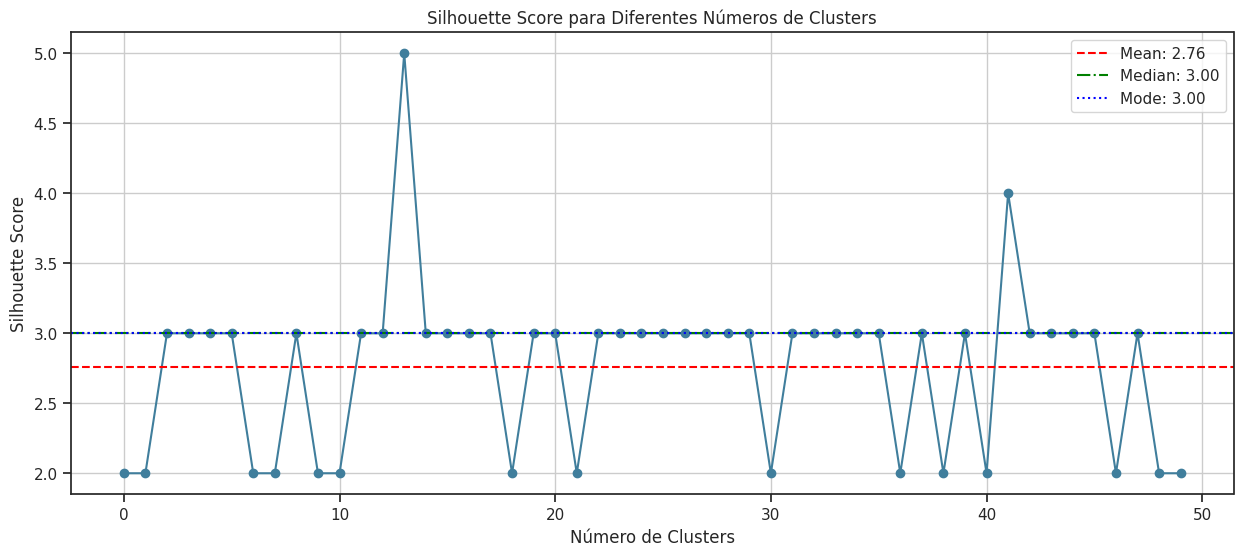

In [30]:
#@title Silhuete Score
plt.figure(figsize=(15, 6))
plt.plot(range(num_samples), stats['silhouete'], marker='o')
plt.title('Silhouette Score para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid()

mean_ = np.mean(stats['silhouete'])
median_ = np.median(stats['silhouete'])
mode_ = float(np.bincount(stats['silhouete']).argmax())

plt.axhline(mean_, color='r', linestyle='--', label=f'Mean: {mean_:.2f}')
plt.axhline(median_, color='g', linestyle='-.', label=f'Median: {median_:.2f}')
plt.axhline(mode_, color='b', linestyle=':', label=f'Mode: {mode_:.2f}')

plt.legend()
plt.show()

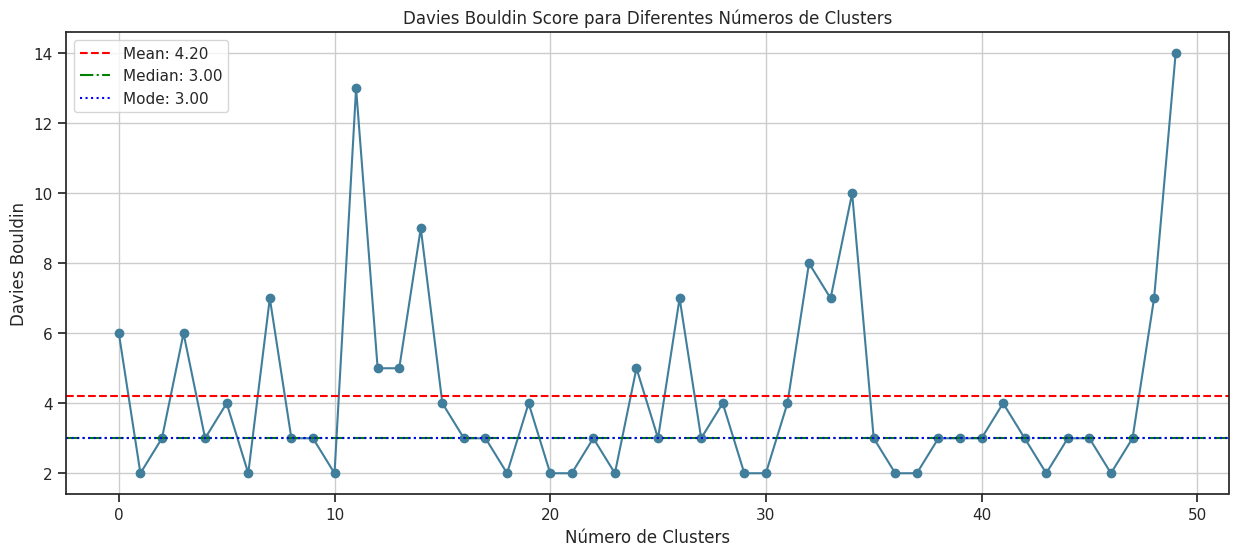

In [31]:
#@title Davies Bouldin Score
plt.figure(figsize=(15, 6))
plt.plot(range(num_samples), stats['davies_bouldin'], marker='o')
plt.title('Davies Bouldin Score para Diferentes Números de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Davies Bouldin')
plt.grid()

mean_ = np.mean(stats['davies_bouldin'])
median_ = np.median(stats['davies_bouldin'])
mode_ = float(np.bincount(stats['davies_bouldin']).argmax())

plt.axhline(mean_, color='r', linestyle='--', label=f'Mean: {mean_:.2f}')
plt.axhline(median_, color='g', linestyle='-.', label=f'Median: {median_:.2f}')
plt.axhline(mode_, color='b', linestyle=':', label=f'Mode: {mode_:.2f}')

plt.legend()
plt.show()

In [33]:
#@title Define Best Features
# Define Clusters
n_clusters = 3
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward'
)
labels = clustering.fit_predict(df_normalized)

# Compute MI
clusters_mi = {}
for cluster_label in np.unique(labels):
    cluster_indexes = labels == cluster_label
    X = df_normalized.iloc[cluster_indexes, :]
    Y = df['Nivel_economico'].iloc[cluster_indexes]

    display(X)
    if len(X) > 2:
        mi = mutual_info_classif(X, Y, random_state=0)
        clusters_mi[cluster_label] = pd.DataFrame(mi.reshape(-1, 1), index=X.keys(), columns=['Mutual_information']).sort_values(by=['Mutual_information'], ascending=False)


#Print Infos
for index in clusters_mi:
    print(f'Cluster {index}')
    display(clusters_mi[index].iloc[:3])

,Analfabeto_freq,Ate_5_incompleto_freq,5_completo_fundamental_freq,6_a_9_fundamental_freq,Fundamental_completo_freq,Medio_incompleto_freq,Medio_completo_freq,Superior_incompleto_freq,Superior_completo_freq,Mestrado_freq,...,5_completo_fundamental_renda,6_a_9_fundamental_renda,Fundamental_completo_renda,Medio_incompleto_renda,Medio_completo_renda,Superior_incompleto_renda,Superior_completo_renda,Mestrado_renda,Doutorado_renda,Total_renda
3196,0.322544,0.731123,0.614555,0.533544,0.583063,0.462513,0.437494,0.444632,0.354888,1.000000,...,0.614555,0.533544,0.583063,0.462513,0.437494,0.444632,0.354888,1.000000,0.65266,0.433968
3768,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.848269,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.848269,1.00000,1.000000


,Analfabeto_freq,Ate_5_incompleto_freq,5_completo_fundamental_freq,6_a_9_fundamental_freq,Fundamental_completo_freq,Medio_incompleto_freq,Medio_completo_freq,Superior_incompleto_freq,Superior_completo_freq,Mestrado_freq,...,5_completo_fundamental_renda,6_a_9_fundamental_renda,Fundamental_completo_renda,Medio_incompleto_renda,Medio_completo_renda,Superior_incompleto_renda,Superior_completo_renda,Mestrado_renda,Doutorado_renda,Total_renda
0,0.006733,0.007897,0.005914,0.005381,0.002637,0.007022,0.005216,0.002852,0.001787,0.002226,...,0.005914,0.005381,0.002637,0.007022,0.005216,0.002852,0.001787,0.002226,0.000781,0.003956
1,0.000243,0.000161,0.000767,0.000323,0.000186,0.000212,0.000193,0.000064,0.000093,0.000000,...,0.000767,0.000323,0.000186,0.000212,0.000193,0.000064,0.000093,0.000000,0.000049,0.000161
2,0.004056,0.008971,0.004806,0.004778,0.003619,0.006048,0.004528,0.003889,0.001811,0.003107,...,0.004806,0.004778,0.003619,0.006048,0.004528,0.003889,0.001811,0.003107,0.001122,0.003689
3,0.000487,0.001307,0.001704,0.001073,0.000564,0.000965,0.000631,0.000379,0.000268,0.000661,...,0.001704,0.001073,0.000564,0.000965,0.000631,0.000379,0.000268,0.000661,0.000000,0.000541
4,0.000649,0.001379,0.000852,0.001158,0.000663,0.000673,0.000615,0.000322,0.000238,0.000000,...,0.000852,0.001158,0.000663,0.000673,0.000615,0.000322,0.000238,0.000000,0.000000,0.000503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,0.000081,0.000161,0.000153,0.000070,0.000076,0.000115,0.000059,0.000014,0.000007,0.000000,...,0.000153,0.000070,0.000076,0.000115,0.000059,0.000014,0.000007,0.000000,0.000000,0.000043
5485,0.001541,0.002417,0.001926,0.002491,0.000892,0.001252,0.000545,0.000440,0.000258,0.000073,...,0.001926,0.002491,0.000892,0.001252,0.000545,0.000440,0.000258,0.000073,0.000000,0.000579
5486,0.001704,0.002758,0.000937,0.002442,0.001154,0.001642,0.000389,0.000211,0.000166,0.000024,...,0.000937,0.002442,0.001154,0.001642,0.000389,0.000211,0.000166,0.000024,0.000000,0.000487
5487,0.000487,0.001021,0.000597,0.000652,0.000229,0.000230,0.000472,0.000043,0.000085,0.000269,...,0.000597,0.000652,0.000229,0.000230,0.000472,0.000043,0.000085,0.000269,0.000000,0.000311


,Analfabeto_freq,Ate_5_incompleto_freq,5_completo_fundamental_freq,6_a_9_fundamental_freq,Fundamental_completo_freq,Medio_incompleto_freq,Medio_completo_freq,Superior_incompleto_freq,Superior_completo_freq,Mestrado_freq,...,5_completo_fundamental_renda,6_a_9_fundamental_renda,Fundamental_completo_renda,Medio_incompleto_renda,Medio_completo_renda,Superior_incompleto_renda,Superior_completo_renda,Mestrado_renda,Doutorado_renda,Total_renda
927,0.170358,0.208373,0.130464,0.179787,0.157954,0.136639,0.189988,0.142080,0.098324,0.159584,...,0.130464,0.179787,0.157954,0.136639,0.189988,0.142080,0.098324,0.159584,0.144949,0.153755
1565,0.144966,0.193117,0.139548,0.167859,0.090393,0.095451,0.136327,0.104106,0.127714,0.249541,...,0.139548,0.167859,0.090393,0.095451,0.136327,0.104106,0.127714,0.249541,0.211664,0.130446
2124,0.084692,0.165022,0.125573,0.100849,0.083043,0.122631,0.179803,0.130900,0.114981,0.146275,...,0.125573,0.100849,0.083043,0.122631,0.179803,0.130900,0.114981,0.146275,0.231918,0.146218
2269,0.181066,0.515641,0.333379,0.303171,0.232151,0.266841,0.235577,0.279235,0.209953,0.424954,...,0.333379,0.303171,0.232151,0.266841,0.235577,0.279235,0.209953,0.424954,0.380185,0.238806
3944,0.110246,0.156965,0.145565,0.140511,0.182991,0.178279,0.176794,0.174576,0.167766,0.245774,...,0.145565,0.140511,0.182991,0.178279,0.176794,0.174576,0.167766,0.245774,0.258858,0.173635
4861,0.073173,0.095386,0.086800,0.155490,0.142833,0.145750,0.108373,0.159052,0.140599,0.248881,...,0.086800,0.155490,0.142833,0.145750,0.108373,0.159052,0.140599,0.248881,0.189409,0.126902
5339,0.115113,0.129318,0.104917,0.174153,0.103454,0.159227,0.130952,0.082680,0.100574,0.104171,...,0.104917,0.174153,0.103454,0.159227,0.130952,0.082680,0.100574,0.104171,0.122938,0.119284
5489,0.158270,0.219725,0.160631,0.223820,0.224884,0.234697,0.219954,0.190714,0.252307,0.489639,...,0.160631,0.223820,0.224884,0.234697,0.219954,0.190714,0.252307,0.489639,0.432455,0.231899


Cluster 1


,Mutual_information
Total_freq,0.245076
Total_renda,0.243424
Medio_completo_renda,0.232729


Cluster 2


,Mutual_information
Medio_incompleto_renda,0.072917
Analfabeto_freq,0.000000
Analfabeto_renda,0.000000
